In [1]:
import chardet
import os
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD   
from nltk.tokenize import word_tokenize
import nltk
from fuzzywuzzy import fuzz
import random

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

/Users/caseykaufman/opt/anaconda3/envs/3350/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/caseykaufman/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
def detect_encoding(file_path):
    with open(file_path, 'rb') as file:
        raw_data = file.read()

    result = chardet.detect(raw_data)
    return result['encoding']

def srt_to_text(srt_file_path):
    encoding_attempts = ['utf-8', 'ISO-8859-1', 'utf-16', ]

    for encoding in encoding_attempts:
        try:
            with open(srt_file_path, 'r', encoding=encoding) as file:
                lines = file.readlines()

            text = ""
            current_line = ""
            is_time_line = True

            for line in lines:
                line = line.strip()

                if not line:
                    is_time_line = True
                    continue

                if is_time_line:
                    is_time_line = False
                    continue

                current_line += line + " "

                # If the line ends with a punctuation indicating the end of a sentence
                if line.endswith(('.', '!', '?')):
                    text += current_line + "\n"
                    current_line = ""

            return text.strip()
        except UnicodeDecodeError:
            None

    # If none of the encodings work
    print(f"Unable to decode file: {srt_file_path}")
    return None

def process_srt_files_in_folder(folder_path):
    result_dict = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".srt"):
            srt_file_path = os.path.join(folder_path, filename)
            text_content = srt_to_text(srt_file_path)

            if text_content is not None:
                file_dict = {"name": filename, "text": text_content}
                result_dict.append(file_dict)

    return result_dict

# Example usage for a folder containing SRT files
wally = '/Users/wally/Library/CloudStorage/OneDrive-Personal/Documents/Cornell/1. Fourth Year/INFO 6350 - Text Mining History and Literature/INFO6350_Final_Project/srt_files'
casey = '/Users/caseykaufman/Documents/GitHub/INFO6350_Final_Project/srt_files'

folder_path = casey

result_dictionary = process_srt_files_in_folder(folder_path)

In [3]:
movie_subtitles_df = pd.DataFrame(result_dictionary)

In [4]:
# Removal of timestamps
movie_subtitles_df['text'] = movie_subtitles_df['text'].str.replace(r'\d{2}:\d{2}:\d{2},\d{3} --> \d{2}:\d{2}:\d{2},\d{3}[\s-]+', '\n', regex=True)
movie_subtitles_df['text'] = movie_subtitles_df['text'].str.replace(r'<font.*?>|<\/font>', '', regex=True)
movie_subtitles_df['text'] = movie_subtitles_df['text'].str.replace(r'\bdownloaded.*?|subtitles downloaded.*?|http.*?|www.*?', '', regex=True, flags=re.IGNORECASE)

In [5]:
pd.options.display.max_rows = 400

In [6]:
years = []
for name_index in range(len(movie_subtitles_df['name'])):
    found_year = False
    for letter_index in range(len(movie_subtitles_df['name'][name_index])):
        if movie_subtitles_df['name'][name_index][letter_index:letter_index+2] == '19' and movie_subtitles_df['name'][name_index][letter_index:letter_index+4].isdigit() or movie_subtitles_df['name'][name_index][letter_index:letter_index+2] == '20' and movie_subtitles_df['name'][name_index][letter_index:letter_index+4].isdigit():
            y = movie_subtitles_df['name'][name_index][letter_index:letter_index+4]
            years.append(y)
            found_year = True
            break
    if not found_year:
        years.append('na')

In [7]:
movie_subtitles_df['years'] = years

In [8]:
#cleaning names
pattern1= r'^([^\d(]+)(?:\.\d{4}| \(\d{4}\))?\.?[^\w]*'
pattern2 = r'^[^a-zA-Z]*(.*?)\.[a-zA-Z]{3}\b'
pattern3 = r'^[^a-zA-Z]*(.*?)\.[a-zA-Z]{3}-'

clean_names = []
for file_name in movie_subtitles_df['name']:
    match = re.match(pattern1, file_name) or re.match(pattern2, file_name) or re.match(pattern3, file_name)
    if match:
        extracted_name = match.group(1).replace('.', ' ')
        clean_names.append(extracted_name)
    else:
        print("Name extraction pattern not found for:", file_name)
        
new = [name.split('WWW')[0].strip() if 'WWW' in name else name for name in clean_names]
clean_names = [x.replace('-','') for x in new]

In [9]:
movie_subtitles_df['Movie Name'] = clean_names

In [10]:
#adding win/loss
excel = pd.read_csv('scripts.csv')

#getting index values
highest = []
for films in clean_names: 
    similarity = []
    indexes = []
    for all_films in excel['Film']:
        sim = fuzz.ratio(str(films), str(all_films))
        similarity.append(sim)
    highest.append(similarity.index(max(similarity)))
    
movie_name_check, win_loss, year = [], [], []

for idx in highest:
    value1 = excel.loc[idx,'Film']
    value2 = excel.loc[idx,'Win']
    value3 = excel.loc[idx,'Year']
    movie_name_check.append(value1)
    win_loss.append(value2)
    year.append(value3)
    
movie_subtitles_df['Similarity Calc Name'] = movie_name_check
movie_subtitles_df['Win or Loss'] = win_loss
movie_subtitles_df['Year'] = year

In [11]:
movie_subtitles_df.head()

,name,text,years,Movie Name,Similarity Calc Name,Win or Loss,Year
0,Sunset Blvd. (1950)_english.srt,"\nYes, this is Sunset Boulevard, Los Angeles, ...",1950,Sunset Blvd,Sunset Boulevard,1.0,1950
1,Diner.1982.720p.BluRay.x264-AMIABLE.srt,\nA little bit softer now - Shout \nA little b...,1982,Diner,Diner,0.0,1982
2,Road.To.Utopia.1945.1080p.BluRay.x264-[YTS.AM]...,"\nFor those of you who don't go to the movies,...",1945,Road To Utopia,Road to Utopia,0.0,1946
3,Tender Mercies (1983).srt,"\nHere, give me the bottle. \n- Go to hell. \n...",1983,Tender Mercies,Tender Mercies,1.0,1983
4,Ghandi.1982.1080p.BluRay.x264.YIFY.srt,\nThere are more than yesterday. \n\nHe will b...,1982,Ghandi,Gandhi,1.0,1982


## Basic Processing and Data Exploration

In [12]:
# Function to count tokens in a text
def count_tokens(text):
    tokens = nltk.word_tokenize(text)
    return len(tokens)

movie_subtitles_df['num_tokens'] = [count_tokens(movie_subtitles_df['text'][i]) for i in range(len(movie_subtitles_df['text']))]

In [13]:
movie_subtitles_df.head()

,name,text,years,Movie Name,Similarity Calc Name,Win or Loss,Year,num_tokens
0,Sunset Blvd. (1950)_english.srt,"\nYes, this is Sunset Boulevard, Los Angeles, ...",1950,Sunset Blvd,Sunset Boulevard,1.0,1950,15458
1,Diner.1982.720p.BluRay.x264-AMIABLE.srt,\nA little bit softer now - Shout \nA little b...,1982,Diner,Diner,0.0,1982,16868
2,Road.To.Utopia.1945.1080p.BluRay.x264-[YTS.AM]...,"\nFor those of you who don't go to the movies,...",1945,Road To Utopia,Road to Utopia,0.0,1946,15171
3,Tender Mercies (1983).srt,"\nHere, give me the bottle. \n- Go to hell. \n...",1983,Tender Mercies,Tender Mercies,1.0,1983,9986
4,Ghandi.1982.1080p.BluRay.x264.YIFY.srt,\nThere are more than yesterday. \n\nHe will b...,1982,Ghandi,Gandhi,1.0,1982,15581


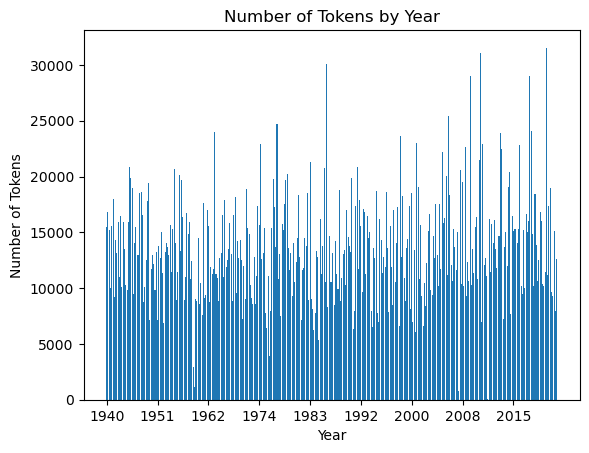

In [14]:
# Filter out rows with 'na' in the 'years' column
movie_subtitles_df = movie_subtitles_df[movie_subtitles_df['years'] != 'na']

# Sort the DataFrame by 'years' in ascending order
movie_subtitles_df = movie_subtitles_df.sort_values(by='years')

# Set x-axis ticks to show only once every other 20 years
step = 40  # Adjust the step value as needed
plt.xticks(range(0, len(movie_subtitles_df['years']), step), movie_subtitles_df['years'][::step])

# Create a bar chart
plt.bar(movie_subtitles_df.index, movie_subtitles_df['num_tokens'])
plt.xlabel('Year')
plt.ylabel('Number of Tokens')
plt.title('Number of Tokens by Year')

plt.show()

## Create Chunks of Tokens out of the Paragraphs

In [15]:
# Create a topic model based on chunking with chunk size 200 tokens

def generate_chunks(paragraphs, movie, year, chunk_size=200):
    chunks = []
    chunk_movie_name = []
    chunk_year = []

    for i in range(len(paragraphs)):
        text = paragraphs.iloc[i]  # Extract the text from the Series
        newsletter_type = movie.iloc[i]
        date = year.iloc[i]

        # Split the text into paragraphs using '\n'
        text_paragraphs = text.split('\n')

        current_chunk = []
        current_chunk_movie_name = []

        for paragraph in text_paragraphs:
            # Check if the length of the paragraph exceeds the chunk size
            if len(paragraph) > chunk_size:
                chunks.append(paragraph)
                chunk_movie_name.append(newsletter_type)
                chunk_year.append(date)
            else:
                # If not, add the paragraph to the current chunk
                current_chunk.append(paragraph)
                current_chunk_movie_name.append(newsletter_type)

                # Check if the current chunk size exceeds the specified limit
                if len(' '.join(current_chunk)) > chunk_size:
                    chunks.append(' '.join(current_chunk))
                    chunk_year.extend([date])
                    chunk_movie_name.append(newsletter_type)
                    current_chunk = []
                    current_chunk_movie_name = []

        # Add any remaining paragraphs to the last chunk
        if current_chunk:
            chunks.append(' '.join(current_chunk))
            chunk_year.extend([date])
            chunk_movie_name.append(newsletter_type)

    return chunks, chunk_movie_name, chunk_year

# Generate chunks
text_chunks, chunk_movie_name, chunk_year = generate_chunks(movie_subtitles_df['text'], movie_subtitles_df['name'], movie_subtitles_df['years'])

## Vectorize

In [16]:
# Vectorizer
vectorizer = CountVectorizer( # Token counts, not normalized (sklearn normalizes later)
    input = 'content',
    encoding = 'utf-8',
    strip_accents = 'unicode',
    #stop_words='english', # uncomment to remove fixed stops from input
    lowercase = True,
    min_df = 0.001, # Remember that we've chunked by paragraph
    max_df = 0.25    # Ditto
)

In [17]:
# Vectorize
vectorizer = TfidfVectorizer(use_idf=True, norm=None)

In [18]:
# Vectorized texts
X_chunked = vectorizer.fit_transform(text_chunks)

#X_topics_chunked = StandardScaler().fit_transform(lda.fit_transform(X_chunked))

## KMeans Cluster Analysis

In [19]:
y_pred = KMeans(n_clusters=3, n_init='auto').fit_predict(X_chunked)

In [20]:
# Plotting function
def plot_compare(X, labels, title, alpha=0.2):
    '''
    Takes an array of object data, a list of cluster labels, a title string, and an optional alpha value.
    Reduces dimensions to 2 if necessary and plots the clustering with and without coloring by label.
    Returns nothing.
    '''
    if X.shape[1] > 2:
        svd = TruncatedSVD(n_components=3)
        X_2d = svd.fit_transform(X)
    else:
        X_2d = X

    # initialize figsize in prompt
    plt.figure(figsize=(12, 6))

    # left subplot, alpha value in function cell
    plt.subplot(121)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], alpha=alpha)
    plt.title("Dimension-Reduced Unclustered Data")

    # right subplot, same coordinate data and supplied cluster labels, alpha value in function cell
    plt.subplot(122)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, alpha=alpha)
    plt.title("Data with Clustering")

    # Set the common title for the entire figure
    plt.title(title)

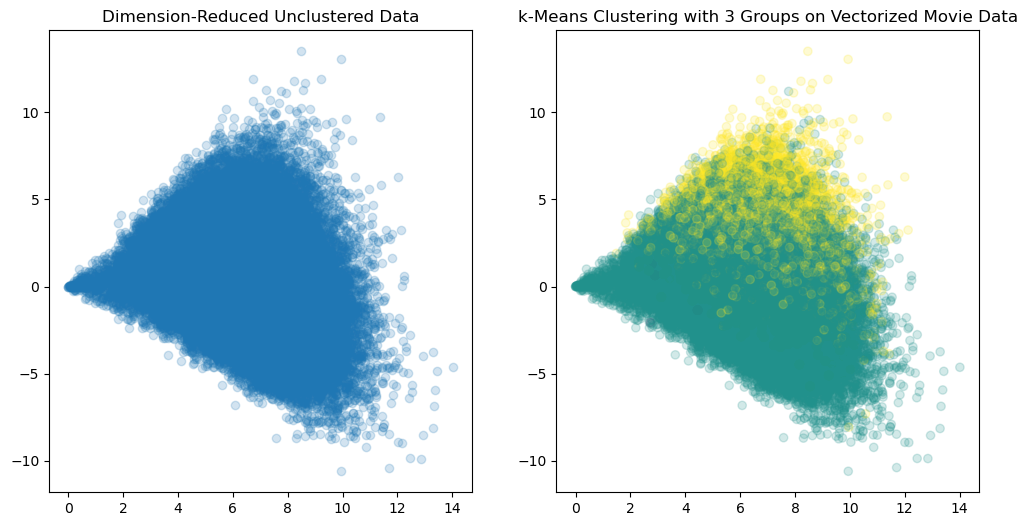

In [21]:
# plot resulting clustering
plot_compare(X_chunked, y_pred, 'k-Means Clustering with 3 Groups on Vectorized Movie Data')

# Topic Model

In [22]:
lda = LatentDirichletAllocation(
    n_components=20, # Number of topics to find
    n_jobs=-1,       # Use all CPU cores
    verbose=0,       # Print progress
    max_iter=30,     # Might want more in production work
    evaluate_every=0 # Set >=1 to test for convergence (slow, but can stop iteration)
)

lda.fit(X_chunked)

LatentDirichletAllocation(evaluate_every=0, max_iter=30, n_components=20,
                          n_jobs=-1)

In [23]:
def print_top_words(model, feature_names, n_top_words, hide_stops=False):
    if hide_stops:
        from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic {topic_idx: >2}: "
        top_words_idx = topic.argsort()
        if not hide_stops:
            top_words = [feature_names[i]
                         for i in top_words_idx[:-n_top_words - 1:-1]]
        else:
            top_words = []
            i = 1
            while len(top_words) < n_top_words:
                if feature_names[top_words_idx[-i]] not in ENGLISH_STOP_WORDS:
                    top_words.append(feature_names[top_words_idx[-i]])
                i += 1
        message += " ".join(top_words)
        print(message)
    print()

In [24]:
print_top_words(lda, vectorizer.get_feature_names_out(), n_top_words=10, hide_stops=False)

Topic  0: uh yeah you oh it okay hi that was no
Topic  1: the of david and in food ray small he an
Topic  2: music playing phone number bill door radio tom speaking tv
Topic  3: the of read is to jack and write in this
Topic  4: the goodbye quiet bob mr slow caught and of ice
Topic  5: la president red de vous french je states united german
Topic  6: thank good you morning hello mr miss yes oh is
Topic  7: three the five kill of two four and six one
Topic  8: the of to and in he is fight our we
Topic  9: lt dick christmas window judge film thе the his camera
Topic 10: the in sir 10 hour and 00 half hours at
Topic 11: the of to and mr is court will in as
Topic 12: you go we ll get come on to here it
Topic 13: ok the you ya black in he and of my
Topic 14: you play sit drink the it water no ma some
Topic 15: she her mother girl wife and was sister whoa the
Topic 16: you to it that know what don do me not
Topic 17: you he was my and me the it love bye
Topic 18: shit fuck fucking man hey yo

# Sentiment Analysis over the decades

For this analysis, we will be looking into the different sentiments within the decades, but also within the winners and losers of our dataset. 

In [25]:
#decades 
# twenties = movie_subtitles_df[(movie_subtitles_df['Year'] >= '1920') & (movie_subtitles_df['Year'] < '1930')]
# thirties = movie_subtitles_df[(movie_subtitles_df['Year'] >= '1930') & (movie_subtitles_df['Year'] < '1940')]
fourties = movie_subtitles_df[(movie_subtitles_df['Year'] >= '1940') & (movie_subtitles_df['Year'] < '1950')]
fifties = movie_subtitles_df[(movie_subtitles_df['Year'] >= '1950') & (movie_subtitles_df['Year'] < '1960')]
sixties = movie_subtitles_df[(movie_subtitles_df['Year'] >= '1960') & (movie_subtitles_df['Year'] < '1970')]
seventies = movie_subtitles_df[(movie_subtitles_df['Year'] >= '1970') & (movie_subtitles_df['Year'] < '1980')]
eighties = movie_subtitles_df[(movie_subtitles_df['Year'] >= '1980') & (movie_subtitles_df['Year'] < '1990')]
ninties = movie_subtitles_df[(movie_subtitles_df['Year'] >= '1990') & (movie_subtitles_df['Year'] < '2000')]
twenty = movie_subtitles_df[(movie_subtitles_df['Year'] >= '2000') & (movie_subtitles_df['Year'] < '2010')]
twenty_ten = movie_subtitles_df[(movie_subtitles_df['Year'] >= '2010') & (movie_subtitles_df['Year'] < '2020')]

In [26]:
years = [fourties, fifties, sixties, seventies, eighties, ninties, twenty, twenty_ten]

In [27]:
fourties.head(1)

,name,text,years,Movie Name,Similarity Calc Name,Win or Loss,Year,num_tokens
304,(1940)Dr.Ehrlich'sMagicBullet.ING.srt,\n[Theme music] \n[Music continues] \n[Music c...,1940,Dr Ehrlich'sMagicBullet,Dr. Ehrlich's Magic Bullet,0.0,1940,14068


In [28]:
def sentiment_score(vader, text_string, name):
    sentiment_dict = vader.polarity_scores(text_string)
    overall_sentiment = 'positive' if sentiment_dict['compound'] >= 0.05 else 'negative' if sentiment_dict['compound'] <= -0.05 else 'neutral'
    # print("Movie:",name)
    # print("neg:      ",sentiment_dict['neg'])
    # print("neu:      ",sentiment_dict['neu'])
    # print("post:      ",sentiment_dict['pos'])
    # print("comp:      ",sentiment_dict['compound'])
    # print("overall sentiment: ", overall_sentiment)
    return sentiment_dict['pos'], sentiment_dict['neg']

In [47]:
#compiling sentiment scores for decades 
names = [1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]
ind = 0
# pos_list, neg_list = [], []
pos_neg = {}
for year in years:
    analyzer = SentimentIntensityAnalyzer()
    pos_list, neg_list = [], []
    for text,movie in zip(year['text'], year['Movie Name']):
        pos, neg = sentiment_score(analyzer, str(text), movie)
        pos_list.append(pos)
        neg_list.append(neg)
    pos_neg[f"{names[ind]}_pos"] = pos_list
    pos_neg[f"{names[ind]}_neg"] = neg_list
    ind += 1

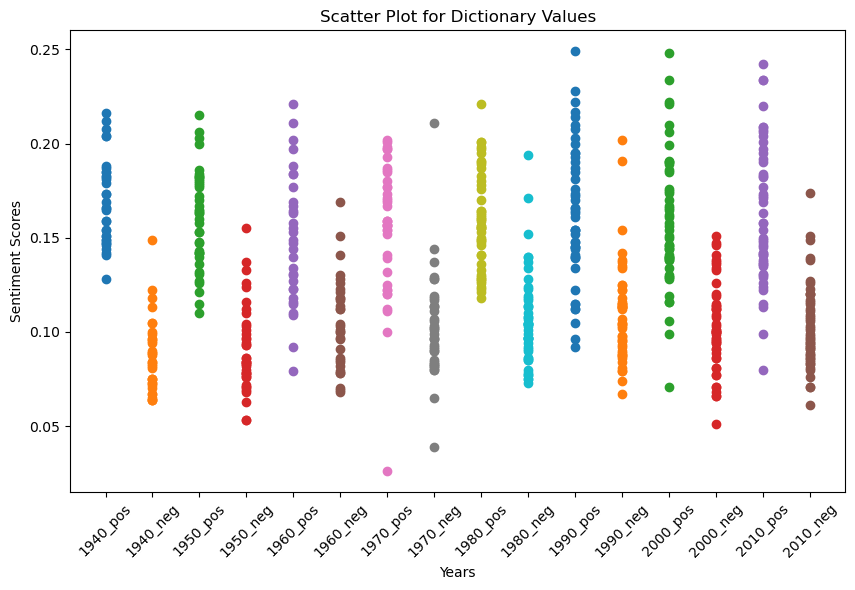

In [48]:
plt.figure(figsize=(10, 6))
plt.title('Scatter Plot for Dictionary Values')
plt.xticks(rotation=45)
plt.xlabel('Years')
plt.ylabel('Sentiment Scores')

for key, values in pos_neg.items():
    plt.scatter([key] * len(values), values, label=key)

plt.show()

In [49]:
#winners or losers 
winners = movie_subtitles_df[(movie_subtitles_df['Win or Loss'] == 1)]
losers = movie_subtitles_df[(movie_subtitles_df['Win or Loss'] == 0)]

In [32]:
# names = ['wins', 'losses']
# ind = 0
# for group in [winners, losers]:
#     analyzer = SentimentIntensityAnalyzer()
#     text = [' '.join(text_snippet) for text_snippet in group['text']]
#     sentiment_score(analyzer, str(text), names[ind])
#     ind +=1

In [78]:
names = ['wins', 'losses']
ind = 0
# pos_list, neg_list = [], []
win_loss = {}
for group in [winners, losers]:
    analyzer = SentimentIntensityAnalyzer()
    pos_list, neg_list = [], []
    for text, movie in zip(group['text'], group['Movie Name']):
        pos, neg = sentiment_score(analyzer, str(text), movie)
        pos_list.append(pos)
        neg_list.append(neg)
    win_loss[f"{names[ind]}_pos"] = pos_list
    win_loss[f"{names[ind]}_neg"] = neg_list
    ind += 1

In [79]:
# for x in zip(win_loss['wins_pos'],win_loss['losses_pos']):
#     print(x)


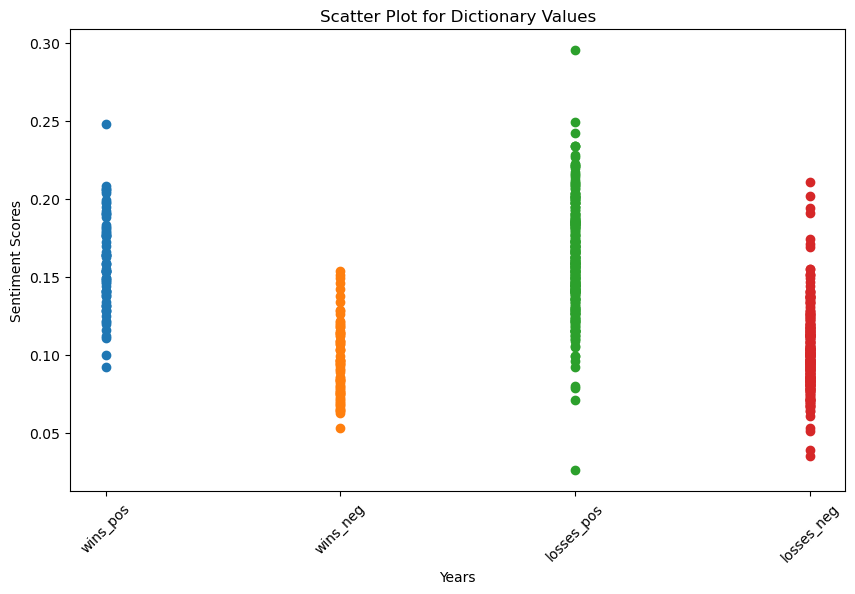

In [80]:
plt.figure(figsize=(10, 6))
plt.title('Scatter Plot for Dictionary Values')
plt.xticks(rotation=45)
plt.xlabel('Years')
plt.ylabel('Sentiment Scores')
for key, values in win_loss.items():
    plt.scatter([key] * len(values), values, label=key)

plt.show()